## Load the Motion Data

Data is in x and y coordinates for each pixel. Each sample will be an array of 10 (frames) x 40 x 40 (capture window) x 2 (x and y) dimensions. 

In [19]:
import numpy as np
import os
import matplotlib
import pandas as pd
# matplotlib.use('TkAgg') # For displaying animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from helper_functions import *
from normalize_data import *
from integral_try import *
from numpy import array
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn import linear_model as lm
from sklearn import svm as svm
from sklearn import ensemble as ensemble
%matplotlib notebook

In [20]:
data_dir = 'sonic_pi_face/data/'

# Get list of data files
data_files = get_data_files(data_dir)

# Load data into a dictionary
# Note: Checks for incomplete data
data = get_gesture_data(data_files)

# Normalize data across data samples and frames (x and y will be normalized independently)
# data = normalize_data(data)
print(np.shape(data['open-close']))

# Load first data sample from `open-close`
sample = data['open-close'][0]
print(np.shape(sample))

# calculate the integral image
iimage = i_image(sample[4])

# calculate the integral for the first quarter from the integral image
try_integral = get_integral(iimage,0,0,20,20)

print('Example integral of the 1st quarter of one frame: ', try_integral)

Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-13_112555_slide-vertically.txt
Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-13_112621_slide-vertically.txt
Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-13_112807_slide-vertically.txt
Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-13_113118_slide-vertically.txt
Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-13_113226_slide-vertically.txt
Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-12_135653_slide-horizontally.txt
Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-13_113507_waving-beauty-pageant-style.txt
Incomplete data sample found at  C:\Users\kle\Documents\sonic-face\sonic_pi_face\data\2017-06-13_113523_waving-b

## List gestures

In [21]:
gestures = list(data)
print(gestures)
g1 = data[gestures[3]][0]

['open-close', 'slide-vertically', 'empty', 'slide-horizontally', 'waving-beauty-pageant-style']


## Visualize optical flow sample frame

<IPython.core.display.Javascript object>


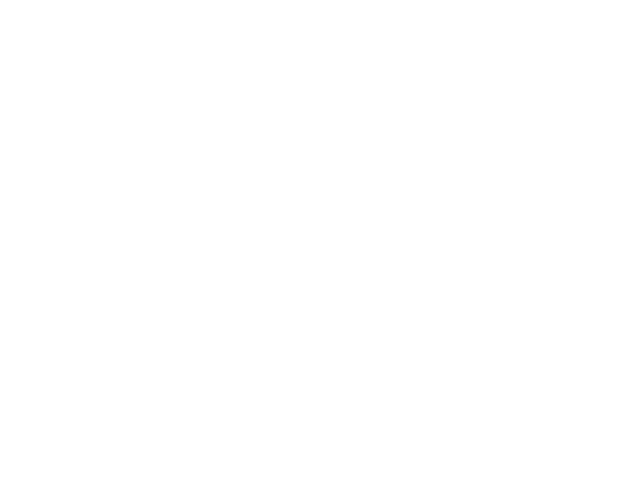

In [22]:
sample = g1[:,:,:,:]
image = sample[6]
# plt.imshow(image[...,0])
# plt.show()

## Get integral image of frame

In [23]:
get_integral(image,0,0,20,20)

array([  3.4018,  12.8266])

## Reduce dimensions with integral image

In [24]:
def reduce_dimensions(rows = 2, cols = 2):
    array = np.zeros((10,rows*cols,2))
    # FIXME: Dynamically define x and y positions based on `rows` and `columns`
    sections= [(0,0,20-1,20-1),(0,20-1,20-1,40-1),(20-1,0,40-1,20-1),(20-1,20-1,40-1,40-1)]
    for ind,frame in enumerate(sample):
        image = i_image(frame)
        for sect_ind, section in enumerate(sections):
            feature = get_integral(image, *section)
            array[ind][sect_ind] = feature
    return array

## Concatenate samples into array

In [25]:
iimage[...,0].sum()

366603.84349999996

## Pandas dataframes for organizing the data

In [44]:
len(data['empty'])

In [ ]:
for gesture in list(data):
    gesture_array = np.zeros((len(data[gesture]),10))
    for sample in gesture_array:
        sample = reduce_dimensions(sample)

## Visualize horizontal motion across frames

In [26]:
sample = data['open-close'][121] # Fifth sample
frame = sample[5][:,:,0] # Middle frame
# Note: Second argument takes 0 for `x`, 1 for `y` coordinate
# display_frames(sample,0) 

## Create training and test data split

Create training and test data split for classification

In [27]:
def get_data(data, key):
    data_list = data[key]
    data_array = np.asarray(data_list)

    # Flatten array to n x 32000
    flattened_data = data_array.reshape((len(data_array),10*1600*2))
    return flattened_data

def scale(data, target_gesture):
    data *= (np.max(target_gesture) + np.abs(np.min(target_gesture))) - np.min(target_gesture)
    return data

In [28]:
# Load target gesture data
open_close_X = get_data(data, 'open-close')
open_close_Y = np.ones((len(open_close_X)))

In [29]:
# Load empty (no-gesture) data
empty_X = get_data(data, 'empty')
empty_Y = np.zeros(len(empty_X))

In [30]:
# Load other gesture
slide_horizontal_X = get_data(data,'slide-horizontally')
slide_horizontal_Y = np.zeros((len(slide_horizontal_X)))

In [31]:
# Load other gesture
beauty_pageant_X = get_data(data, 'waving-beauty-pageant-style')
beauty_pageant_Y = np.zeros((len(beauty_pageant_X)))

In [32]:
X = np.vstack([open_close_X, empty_X, slide_horizontal_X, beauty_pageant_X])
Y = np.hstack([open_close_Y, empty_Y, slide_horizontal_Y, beauty_pageant_Y])

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

## Random Forest

In [33]:
clf_forest = RandomForestClassifier(n_estimators=10)
clf_forest = clf_forest.fit(X_train, y_train)
print(clf_forest.score(X_test,y_test))

0.913793103448


## Adaboost

In [34]:
clf_adaboost = ensemble.AdaBoostClassifier()
clf_adaboost = clf_adaboost.fit(X_train, y_train)

print(clf_adaboost.score(X_test,y_test))

0.956896551724


## Bagging

In [35]:
clf_bagging = ensemble.BaggingClassifier()
clf_bagging = clf_bagging.fit(X_train, y_train)
print(clf_bagging.score(X_test,y_test))

0.870689655172


## Extra randomized trees

In [36]:
clf_extra_tree = ensemble.ExtraTreesClassifier()
clf_extra_tree = clf_extra_tree.fit(X_train, y_train)
print(clf_extra_tree.score(X_test,y_test))

0.939655172414


## Gradient boosting

In [37]:
clf_gradient_boosting = ensemble.GradientBoostingClassifier()
clf_gradient_boosting = clf_gradient_boosting.fit(X_train, y_train)
print(clf_gradient_boosting.score(X_test,y_test))

0.922413793103


## Multilayer Perceptron

In [38]:
clf_mlpc = mlpc()
clf_mlpc = clf_mlpc.fit(X_train, y_train)
print(clf_mlpc.score(X_test,y_test))

0.931034482759


## SVM

In [39]:
clf_svm = svm.SVC(decision_function_shape='ovo')
clf_svm = clf_svm.fit(X_train, y_train)
print(clf_svm.score(X_test,y_test))

0.913793103448


## Logistic Regression

In [40]:
clf_logistic = lm.LogisticRegression(multi_class = 'ovr')
clf_logistic = clf_logistic.fit(X_train, y_train)
print(clf_logistic.score(X_test,y_test))

0.887931034483


## Multiclass Random Forest Classification

In [42]:
X = df2.drop(['Target','label'], axis=1)
Y = df2['Target']

(347, 32002)

In [43]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
# Classify test data using random forest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
accuracy = clf.score(X_test,y_test)
print("Predictions:\n{}".format(clf.predict(X_test)))
print("Actual:\n{}".format(y_test[:10]))
print("Score:\n{}".format(accuracy))

ValueError: could not convert string to float: 'Open'

## [WIP] Decision Tree Visualization


In [ ]:
# FIXME: Test once number of features is less than 360

# Get features
features = df2.columns[:-2]
y = df2["Target"]
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(X, y)

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
visualize_tree(dt,features)